
## Import pyactigraphy library + basic libraries

This notebook is absolutely based on PyActigraphy, a package developed by Grégory Hammad (https://github.com/ghammad/pyActigraphy)


In [2]:
import pyActigraphy

In [3]:
import plotly.graph_objs as go

In [4]:
import pandas as pd
import numpy as np

___


## Import RAW file(s)

In [5]:
rawAWD = pyActigraphy.io.read_raw_awd('example_10.CSV')

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:2327: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



___

## Raw File - Basic Features

In [6]:
rawAWD.start_time

Timestamp('2018-01-23 19:00:00')

In [7]:
rawAWD.frequency

Timedelta('0 days 00:01:00')

In [8]:
rawAWD.data

2018-01-23 19:00:00       0
2018-01-23 19:01:00    1994
2018-01-23 19:02:00    1976
2018-01-23 19:03:00      12
2018-01-23 19:04:00     573
                       ... 
2018-02-02 05:14:00      13
2018-02-02 05:15:00      48
2018-02-02 05:16:00      14
2018-02-02 05:17:00       5
2018-02-02 05:18:00       0
Freq: T, Length: 13579, dtype: int64

In [9]:
rawAWD.data.index

DatetimeIndex(['2018-01-23 19:00:00', '2018-01-23 19:01:00',
               '2018-01-23 19:02:00', '2018-01-23 19:03:00',
               '2018-01-23 19:04:00', '2018-01-23 19:05:00',
               '2018-01-23 19:06:00', '2018-01-23 19:07:00',
               '2018-01-23 19:08:00', '2018-01-23 19:09:00',
               ...
               '2018-02-02 05:09:00', '2018-02-02 05:10:00',
               '2018-02-02 05:11:00', '2018-02-02 05:12:00',
               '2018-02-02 05:13:00', '2018-02-02 05:14:00',
               '2018-02-02 05:15:00', '2018-02-02 05:16:00',
               '2018-02-02 05:17:00', '2018-02-02 05:18:00'],
              dtype='datetime64[ns]', length=13579, freq='T')

___

## Basic Raw Visualization and computation

In [10]:
rawAWD.data.sum()

41288250

In [11]:
rawAWD.data.mean()

3040.595772884601

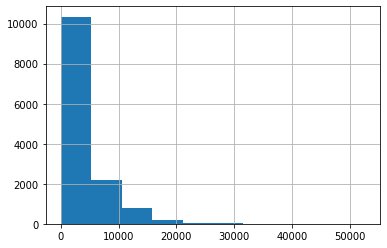

In [12]:
rawAWD.data.hist()

In [13]:
rawAWD.data.idxmax()

Timestamp('2018-01-31 19:43:00', freq='T')

In [14]:
rawAWD.data.idxmin()

Timestamp('2018-01-23 19:00:00', freq='T')

In [16]:
data = rawAWD.data

In [20]:
GT1000 = rawAWD.data[data > 1000] # values greater than 1000 or any specified value

In [18]:
GT1000index = rawAWD.data.index[data > 1000]

In [19]:
GT1000.sum() 

40518595

In [22]:
from plotly.graph_objs import Figure, FigureWidget, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

In [23]:
layout = Layout(
    title="Raw Actimetry data",
    xaxis=dict(title="Date time"), 
    yaxis=dict(title="Activity/phase"), 
    showlegend=False
)

iplot(Figure(data=[Scatter(x=rawAWD.data.index, y=rawAWD.data)], layout=layout))

In [24]:
layout1 = Layout(
    title="Raw Actimetry values greater than 1000",
    xaxis=dict(title="Date time"), 
    yaxis=dict(title="Activity/phase"), 
    showlegend=False
)
iplot(Figure(data=[Scatter(x=GT1000index, y=GT1000, mode='markers',)], layout=layout1))

___

## Activity Onset and Offset (data from sensor)

In [26]:
A_Onset = rawAWD.AonT(freq='10min', binarize=True)
A_Onset

Timedelta('0 days 05:10:00')

In [25]:
A_Offset = rawAWD.AoffT(freq='10min', binarize=True)
A_Offset

Timedelta('0 days 21:10:00')

___

## Basic Non-Parametric Variables

In [12]:
rawAWD.IS()

0.6669903091223752

In [13]:
rawAWD.IS(freq='30min', binarize=True, threshold=4)

0.5948817919181147

In [14]:
rawAWD.IS(freq='1H', binarize=False)

0.6417327242490838

In [15]:
rawAWD.IVm()

0.40841216212282

In [16]:
rawAWD.IV(freq='1H', binarize=False)

0.7134589684331468

In [17]:
rawAWD.IVm()

0.40841216212282

In [18]:
rawAWD.IV()

0.5781122600451601

In [19]:
rawAWD.IV(freq='1H', binarize=False)

0.7134589684331468

In [20]:
rawAWD.RA()

0.515196707131578

In [21]:
rawAWD.RA(binarize=False)

0.9133219652803318

In [22]:
rawAWD.M10()

0.9407407407407389

In [23]:
rawAWD.L5()

0.3009999999999893

___

## Specific Light non-parametric variables: M16 and M3 (dependencies: _lmx, average_daily_activity)

Used when light exposition data is loaded, instead of rest-activity data. M16 and M3

In [27]:
def _lmx(data, period, lowest=True):
    """Calculate the start time and mean activity of the period of
    lowest/highest activity"""

    avgdaily = _average_daily_activity(data, cyclic=True)

    n_epochs = int(pd.Timedelta(period)/avgdaily.index.freq)

    mean_activity = avgdaily.rolling(period).sum().shift(-n_epochs+1)

    if lowest:
        t_start = mean_activity.idxmin()
    else:
        t_start = mean_activity.idxmax()

    lmx = mean_activity[t_start]/n_epochs
    return t_start, lmx


In [28]:
def _average_daily_activity(data, cyclic=False):
    """Calculate the average daily activity distribution"""

    avgdaily = data.groupby([
        data.index.hour,
        data.index.minute,
        data.index.second
    ]).mean()

    if cyclic:
        avgdaily = pd.concat([avgdaily, avgdaily])
        index = pd.timedelta_range(
            start='0 day',
            end='2 days',
            freq=data.index.freq,
            closed='left'
        )
    else:
        index = pd.timedelta_range(
            start='0 day',
            end='2 day',
            freq=data.index.freq,
            closed='left'
        )

    avgdaily.index = index

    return avgdaily

In [29]:
def M16(self, binarize=True, threshold=4):
    if binarize is True:
            data = self.binarized_data(threshold)
    else:
            data = self.data

            _, M16 = _lmx(data, '16H', lowest=False)

    return M16



In [30]:
def M3(self, binarize=True, threshold=4):
    if binarize is True:
            data = self.binarized_data(threshold)
    else:
            data = self.data

            _, M16 = _lmx(data, '3H', lowest=False)

    return M16



In [31]:
M16(rawAWD, binarize=False, threshold=4)

4496.012754629634

In [32]:
M3(rawAWD, binarize=False, threshold=4)

6302.959259259249

___

## Non-Parametric phases (Low and Max)

In [33]:
data = rawAWD.data


In [34]:
L_onset = _lmx(data, 30, lowest=True)
L_onset


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in double_scalars



(Timedelta('0 days 03:58:00'), inf)

In [35]:
M_onset= _lmx(data, 30, lowest=False)
M_onset

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in double_scalars



(Timedelta('1 days 09:44:00'), inf)

___

## Total Sum - Activity 24h profile (observe the frequency, freq= in average daily activity) + Average daily Activity

In [36]:
Average = rawAWD.average_daily_activity(freq='60min', cyclic=False, binarize=True, threshold=4)
Average 
Average_Activity = np.sum(Average, axis=0)
Average_Activity

970.4777777777778

In [37]:
daily_profile = rawAWD.average_daily_activity(freq='60min', cyclic=True, binarize=True, threshold=4)

In [38]:
daily_profile.mean()

40.43657407407408

In [39]:
daily_profile.median()

46.238888888888894

In [40]:
from scipy import ndimage

In [43]:
ndimage.measurements.center_of_mass(daily_profile) # to calculate the center of gravity or centroid (/2 if 60_)

(24.80383087368192,)

In [44]:
ndimage.measurements.center_of_mass(daily_profile.index) # to calculate the center of gravity or centroid (/2 if 60_)

(31.666666666666668,)

In [45]:
daily_profile.sum() # 2x Lux, because of cyclic=True on daily profile calculation

1940.9555555555555

In [46]:
daily_profile.idxmax()

Timedelta('0 days 17:00:00')

In [47]:
daily_profile.idxmin()

Timedelta('0 days 03:00:00')

In [49]:
ProfileGTx = daily_profile[daily_profile>40] # have to specify the value (standard: > 1000 counts)

In [50]:
ProfileGTx.sum()

1415.7777777777778

In [51]:
ProfileGTx.mean()

54.452991452991455

In [52]:
ProfileGTx.idxmax()

Timedelta('0 days 17:00:00')

In [53]:
ProfileGTx.idxmin()

Timedelta('0 days 20:00:00')

In [57]:
ProfileGTxindex = ProfileGTx.index[ProfileGTx>40]

In [58]:
ProfileGTxindex 

TimedeltaIndex(['0 days 08:00:00', '0 days 09:00:00', '0 days 10:00:00',
                '0 days 11:00:00', '0 days 12:00:00', '0 days 13:00:00',
                '0 days 14:00:00', '0 days 15:00:00', '0 days 16:00:00',
                '0 days 17:00:00', '0 days 18:00:00', '0 days 19:00:00',
                '0 days 20:00:00', '1 days 08:00:00', '1 days 09:00:00',
                '1 days 10:00:00', '1 days 11:00:00', '1 days 12:00:00',
                '1 days 13:00:00', '1 days 14:00:00', '1 days 15:00:00',
                '1 days 16:00:00', '1 days 17:00:00', '1 days 18:00:00',
                '1 days 19:00:00', '1 days 20:00:00'],
               dtype='timedelta64[ns]', freq=None)

___

#### Average 24-h profile View (single or double plot, according to cyclic argument in daily_profile)

In [59]:
layout.update(title="24-h profile - Double plot",xaxis=dict(title="Time"), showlegend=False);


In [60]:
go.Figure(data=[
    go.Scatter(x=daily_profile.index.astype(str), y=daily_profile)
], layout=layout)

In [63]:
layout1 = Layout(
    title="24-h Profile with values greater than X ",
    xaxis=dict(title="Date time"), 
    yaxis=dict(title="Activity/phase"), 
    showlegend=False
    
)
iplot(Figure(data=[Scatter(x=ProfileGTxindex, y=ProfileGTx, mode='markers',)], layout=layout1))

___

## Total Counts (PyActigraphy Methods)

In [64]:
rawAWD.ADAT(binarize=True, threshold=4)

820.5454545454545

In [65]:
#rawAWD.ADATp(period='7D', binarize=True, threshold=4, verbose=False)
rawAWD.ADATp(period= '7D', binarize=True, threshold=4, verbose=True)

Number of periods: 1
 Time unaccounted for: 2 days, 10h, 18m, 0s


[844.0]

___

## Area Under the Curve (AUC) - 24-h Profile - Total

In [164]:
daily_profile1 = rawAWD.average_daily_activity(freq='60min', cyclic=True, binarize=True, threshold=4)
AUC_total = (np.trapz(daily_profile1, axis=0)/2)
AUC_total

960.7527777777777

___

## Area Under the Curve (AUC) - 24-h Profile - Partial (View + Calculation)

### 1. According to Sleep-wake cycle

In [70]:
Soff = 5 # example

In [71]:
Son = 21 # example

In [72]:
Soff2 = 29 # example, to compute sleep duration

In [74]:
df = pd.DataFrame(np.array(daily_profile), columns=['y'])
AUC_wake = np.trapz(df['y'][Soff:Son])
AUC_Sleep = np.trapz(df['y'][Son:Soff2])

In [75]:
AUC_wake

768.0277777777777

In [76]:
AUC_Sleep

142.4

In [77]:
from plotly.subplots import make_subplots
from plotly.graph_objs import Figure, FigureWidget, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
layout.update(title="Partial Activity profile - Wake",xaxis=dict(title="Time"), showlegend=False);


init_notebook_mode(connected=True)

In [78]:
go.Figure(data=[
    go.Scatter(x=daily_profile.index.astype(str), y = (df['y'][Soff:Son]))
], layout=layout)

In [79]:
layout.update(title="Partial Activity profile - Sleep",xaxis=dict(title="Time"), showlegend=False);

In [80]:
go.Figure(data=[
    go.Scatter(x=daily_profile.index.astype(str), y = (df['y'][Son:Soff2]))
], layout=layout)

### 2. According to natural LD Cycle (check Lat x Long)

In [81]:
daily_profile_luz = rawAWD.average_daily_activity(freq='60min', cyclic=True, binarize=True, threshold=4)

In [85]:
Lon = 6 # example of natural LD, sunrise = 6h, sunset = 18h

In [86]:
Loff = 18

In [87]:
Lon2 = 30

In [88]:
df2 = pd.DataFrame(np.array(daily_profile_luz), columns=['y'])
AUC_Day = np.trapz(df2['y'][Lon:Loff])
AUC_Night = np.trapz(df2['y'][Loff:Lon2])

In [89]:
AUC_Day

573.9444444444445

In [90]:
AUC_Night

309.2111111111111

In [91]:
from plotly.subplots import make_subplots
from plotly.graph_objs import Figure, FigureWidget, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
layout.update(title="Partial Activity profile - Day",xaxis=dict(title="Time"), showlegend=False);


init_notebook_mode(connected=True)

In [92]:
go.Figure(data=[
    go.Scatter(x=daily_profile.index.astype(str), y = (df2['y'][Lon:Loff]))

], layout=layout)

In [93]:
layout.update(title="Partial Activity profile - Night",xaxis=dict(title="Time"), showlegend=False);

go.Figure(data=[
    go.Scatter(x=daily_profile.index.astype(str), y = (df2['y'][Loff:Lon2]))

], layout=layout)

### 3. Count Activity from Sunset to Sleep Onset

In [94]:
AUC_Sunset_SleepOnset = np.trapz(df2['y'][Loff:Son])
AUC_Sunset_SleepOnset

106.7611111111111

In [95]:
layout.update(title="Partial Activity profile - Sunset to Sleep Onset",xaxis=dict(title="Time"), showlegend=False);
go.Figure(data=[
    go.Scatter(x=daily_profile.index.astype(str), y = (df2['y'][Loff:Son]))

], layout=layout)

__________

## Cosinor Analysis ??

_____

## Log-transformated data

Important to run light exposition data instead of rest-activity

In [96]:
log10_value = np.log10(rawAWD.data)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log10



In [97]:
log10_value

2018-01-23 19:00:00        -inf
2018-01-23 19:01:00    3.299725
2018-01-23 19:02:00    3.295787
2018-01-23 19:03:00    1.079181
2018-01-23 19:04:00    2.758155
                         ...   
2018-02-02 05:14:00    1.113943
2018-02-02 05:15:00    1.681241
2018-02-02 05:16:00    1.146128
2018-02-02 05:17:00    0.698970
2018-02-02 05:18:00        -inf
Freq: T, Length: 13579, dtype: float64

In [100]:
layout = Layout(
    title="Raw Activity data",
    xaxis=dict(title="Date time"), 
    yaxis=dict(title="Activity/phase"), 
    showlegend=False
)

iplot(Figure(data=[Scatter(x=rawAWD.data.index, y=log10_value)], layout=layout))